## Sentiment Analysis Using NLTK

### Hotel Reviews from Trip Advisor 

<img src="assets/review.png" alt="Hotel Review" style="width:200px">

#### Data source: [TripAdvisor Hotel Reviews](https://www.kaggle.com/datasets/thedevastator/tripadvisor-hotel-reviews)


### Import NLTK Packages

In [1]:
import numpy as np # for array, linear algebra
import pandas as pd # for data processing
import matplotlib.pyplot as plt 

In [2]:
from nltk import pos_tag # Part-of-Speech (POS) tagging
from nltk.stem import WordNetLemmatizer # lemmatize a word
from nltk.corpus import wordnet # large lexical database of English words
import nltk as nltk
from wordcloud import WordCloud # to visualize text
from sklearn.feature_extraction.text import TfidfVectorizer # converts a collection of raw documents into a matrix
from gensim.models.doc2vec import Doc2Vec, TaggedDocument #  representing documents as a vector

### Load dataset

In [3]:
df = pd.read_csv('data/trip_advisor_reviews.csv', encoding = 'ISO-8859-1')
df.head()

,S.No.,Review,Rating
0,1,nice hotel expensive parking got good deal sta...,4
1,2,ok nothing special charge diamond member hilto...,2
2,3,nice rooms not 4* experience hotel monaco seat...,3
3,4,unique \tgreat stay \twonderful time hotel mon...,5
4,5,great stay great stay \twent seahawk game awes...,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   S.No.   20491 non-null  int64 
 1   Review  20491 non-null  object
 2   Rating  20491 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 480.4+ KB


### Data cleaning and preprocessing

In [5]:
df = df.sample(frac = 0.1, replace = False, random_state=42)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 10726 to 5934
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chars             2049 non-null   int64  
 1   Words             2049 non-null   int64  
 2   doc2vec_vector_0  2049 non-null   float32
 3   doc2vec_vector_1  2049 non-null   float32
 4   doc2vec_vector_2  2049 non-null   float32
 5   doc2vec_vector_3  2049 non-null   float32
 6   doc2vec_vector_4  2049 non-null   float32
 7   review            2049 non-null   int64  
dtypes: float32(5), int64(3)
memory usage: 104.1 KB


In [6]:
#This column is the same as index
df = df.drop(['S.No.'], axis = 1)

In [7]:
df.isna().sum()

Review    0
Rating    0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/eo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Create a function to help identify type of the words (adjective, verb, noun, adverb)
Remove ‘empty’ review and words with only 1 letter
Lower all text
Tokenize and split text to words
Remove numbers and stop words ( ‘a’, ‘an’, ‘the’, ‘of’, ‘in’, etc.), to help improve accuracy to give more focus to the important information
Part-of-Speech (POS) tagging: Categorizing words in a text (corpus) in correspondence with a particular part of speech, depending on the definition of the word and its context indicates how the word functions in meaning as well as grammatically within the sentence
Lemmatize the text: transform every word into their root form (caring to care)

In [10]:
# return the wordnet object value
import string


def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # remove \t
    text = text.replace('\t', '')
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    text = [x for x in text if x not in stopwords_list]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = ' '.join(text)
    return(text)

In [11]:
df['Clean_Review'] = df['Review'].apply(lambda x: clean_text(x))
df.head()

,Review,Rating,Clean_Review
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer actually stay hotel g...
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...
19098,ok hotel good location stayed night way beijin...,3,ok hotel good location stay night way beijing ...
2450,great service nice pool ok beach lovely ground...,4,great service nice pool ok beach lovely ground...
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...


In [12]:
def count_chars(text):
    return len(text)

def count_words(text):
    return len(text.split())

In [13]:
df['chars'] = df['Clean_Review'].apply(count_chars)
df['Words'] = df['Clean_Review'].apply(count_words)

In [14]:
df.head()

,Review,Rating,Clean_Review,chars,Words
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer actually stay hotel g...,259,38
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...,2246,332
19098,ok hotel good location stayed night way beijin...,3,ok hotel good location stay night way beijing ...,152,24
2450,great service nice pool ok beach lovely ground...,4,great service nice pool ok beach lovely ground...,1837,291
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...,637,92


In [15]:
# create doc2vec vector columns
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['Clean_Review'].apply(lambda x: x.split(' ')))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = df['Clean_Review'].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ['doc2vec_vector_' + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df], axis=1)
df.head()

,Review,Rating,Clean_Review,chars,Words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer actually stay hotel g...,259,38,0.023873,0.097159,0.402785,-0.387811,-0.025646
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...,2246,332,0.047631,2.551092,2.090269,-1.283122,-0.988190
19098,ok hotel good location stayed night way beijin...,3,ok hotel good location stay night way beijing ...,152,24,0.237049,0.271358,0.005066,-0.241969,-0.201539
2450,great service nice pool ok beach lovely ground...,4,great service nice pool ok beach lovely ground...,1837,291,1.619219,1.133844,1.813955,-1.735675,-0.147266
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...,637,92,0.174208,0.738158,0.961837,-0.971134,-0.223183


### Create Positive and Negative review binary column

- For this dataset, we categorize all 5-star review as a Good Review, while all review from 4-star to 1-star, we categorize it as Bad Review.

In [16]:
df['review'] = df['Rating'].apply(lambda x: 0 if x < 5 else 1)

In [17]:
# Calculate Positive and Negative Review

train_pos = df[ df['review'] == 1]
train_pos = train_pos['Clean_Review']
train_neg = df[ df['review'] == 0]
train_neg = train_neg['Clean_Review']

In [18]:
from PIL import Image

def wordCloud_generator(data, color, color_map):
    
    wave_mask = np.array(Image.open('assets/cloud.png'))
    
    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color =color,
                          min_font_size = 12,
                          colormap= color_map,
                          mask = wave_mask
                         ).generate(' '.join(data.values))
    
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis('off')
    
    plt.show() 

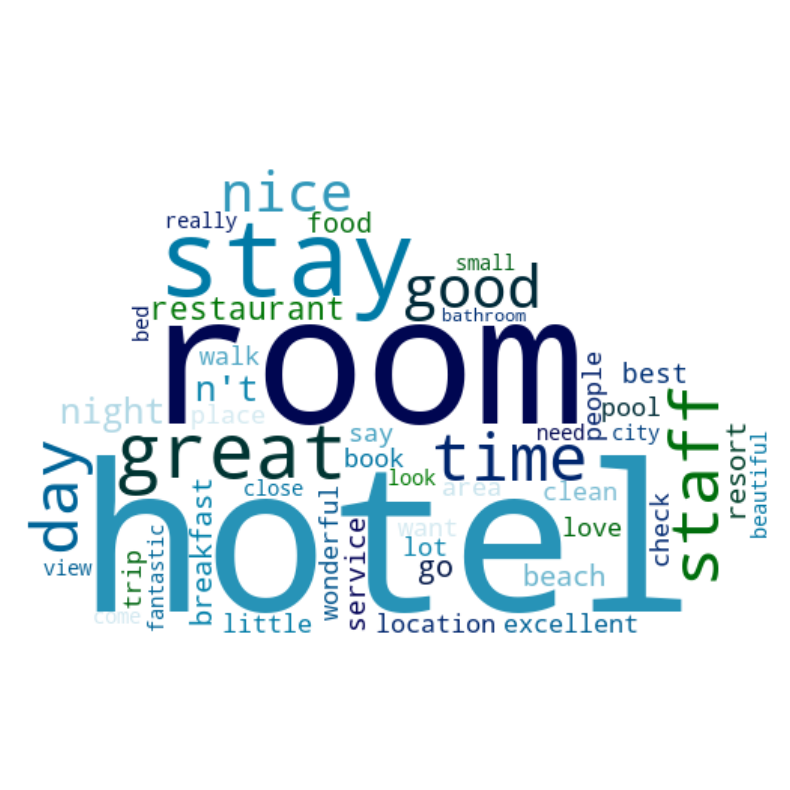

In [19]:
wordCloud_generator(train_pos, 'white', 'ocean')

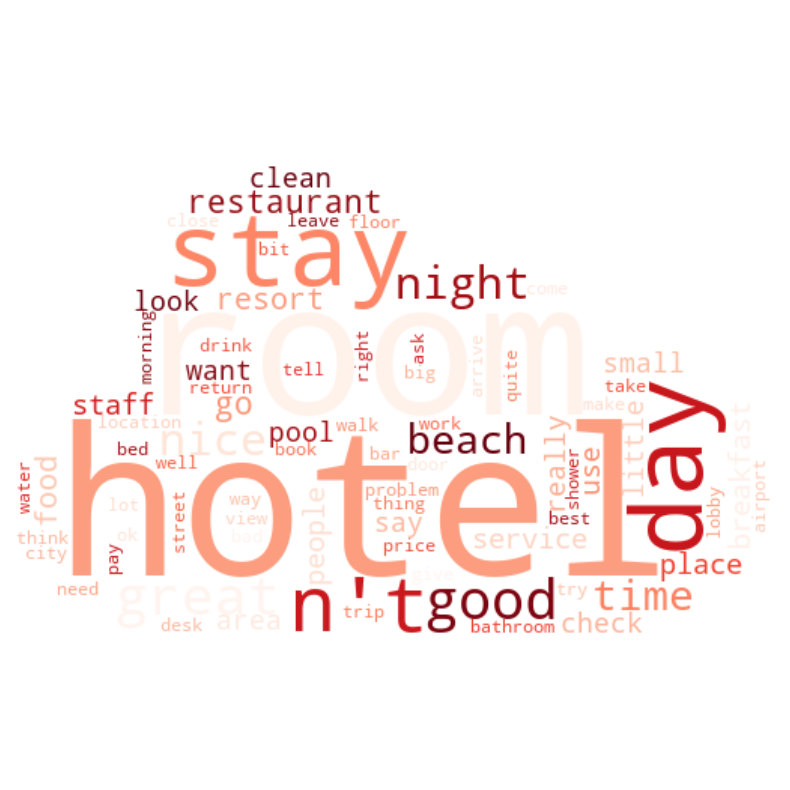

In [20]:
wordCloud_generator(train_neg, 'white', 'Reds')

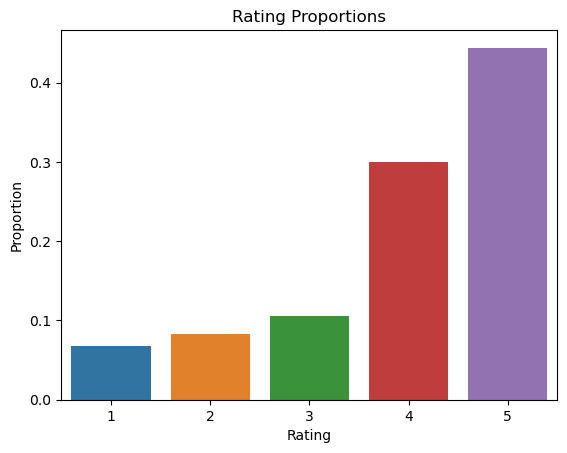

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

rating_proportions = df['Rating'].value_counts(normalize=True).sort_index()

# Crear el gráfico de barras con Seaborn
sns.barplot(x=rating_proportions.index, y=rating_proportions.values)

# Agregar etiquetas y título con Matplotlib
plt.xlabel('Rating')
plt.ylabel('Proportion')
plt.title('Rating Proportions')

# Mostrar el gráfico
plt.show()


### Train Classifier XGBoost

In [22]:
df.head()

,Review,Rating,Clean_Review,chars,Words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,review
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer actually stay hotel g...,259,38,0.023873,0.097159,0.402785,-0.387811,-0.025646,0
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...,2246,332,0.047631,2.551092,2.090269,-1.283122,-0.988190,0
19098,ok hotel good location stayed night way beijin...,3,ok hotel good location stay night way beijing ...,152,24,0.237049,0.271358,0.005066,-0.241969,-0.201539,0
2450,great service nice pool ok beach lovely ground...,4,great service nice pool ok beach lovely ground...,1837,291,1.619219,1.133844,1.813955,-1.735675,-0.147266,0
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...,637,92,0.174208,0.738158,0.961837,-0.971134,-0.223183,1


In [23]:
df = df.drop(['Review', 'Rating', 'Clean_Review'], axis = 1)

In [24]:
X = df.drop(['review'],axis = 1)
Y = df['review']

In [25]:
X.head()

,chars,Words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
10726,259,38,0.023873,0.097159,0.402785,-0.387811,-0.025646
14919,2246,332,0.047631,2.551092,2.090269,-1.283122,-0.988190
19098,152,24,0.237049,0.271358,0.005066,-0.241969,-0.201539
2450,1837,291,1.619219,1.133844,1.813955,-1.735675,-0.147266
960,637,92,0.174208,0.738158,0.961837,-0.971134,-0.223183


In [26]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

In [27]:
""" tfidf_vectorizer = TfidfVectorizer()
# Obtener los valores de la columna 'clean_review' en cada conjunto
X_train_clean_review = X_train['Clean_Review'].values
X_test_clean_review = X_test['Clean_Review'].values
X_val_clean_review = X_val['Clean_Review'].values

# Convertir la columna 'clean_review' en características numéricas utilizando TfidfVectorizer
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean_review)
X_test_tfidf = tfidf_vectorizer.transform(X_test_clean_review)
X_val_tfidf = tfidf_vectorizer.transform(X_val_clean_review) """

" tfidf_vectorizer = TfidfVectorizer()\n# Obtener los valores de la columna 'clean_review' en cada conjunto\nX_train_clean_review = X_train['Clean_Review'].values\nX_test_clean_review = X_test['Clean_Review'].values\nX_val_clean_review = X_val['Clean_Review'].values\n\n# Convertir la columna 'clean_review' en características numéricas utilizando TfidfVectorizer\nX_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean_review)\nX_test_tfidf = tfidf_vectorizer.transform(X_test_clean_review)\nX_val_tfidf = tfidf_vectorizer.transform(X_val_clean_review) "

In [28]:
y_val.shape

(717,)

In [29]:
y_test.shape

(615,)

In [30]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10)
    }

    model = XGBClassifier(random_state=42, **params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

best_params = study.best_params

best_model = XGBClassifier(random_state=42, **{f'xgb_{key}': value for key, value in best_params.items()})

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
classification = (classification_report(y_val, y_pred))
print(classification)

/usr/local/anaconda3/envs/llsm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-07-10 19:23:36,649] A new study created in memory with name: no-name-e2526aa9-ef62-4826-b0f9-bc17b59a0f47
/var/folders/1b/q0vy8pzj2d5_w7tb8dkfmh2m0000gn/T/ipykernel_83941/2373162873.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
[I 2023-07-10 19:23:37,092] Trial 0 finished with value: 0.603905160390516 and parameters: {'n_estimators': 761, 'learning_rate': 0.00304332351207189, 'max_depth': 4}. Best is trial 0 with value: 0.603905160390516.
/var/folders/1b/q0vy8pzj2d5_w7tb8dkfmh2m0000gn

              precision    recall  f1-score   support

           0       0.64      0.70      0.67       402
           1       0.57      0.50      0.54       315

    accuracy                           0.62       717
   macro avg       0.61      0.60      0.60       717
weighted avg       0.61      0.62      0.61       717



### SHAP Values

In [31]:
import shap
explainer = shap.TreeExplainer(best_model)

/usr/local/anaconda3/envs/llsm/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/anaconda3/envs/llsm/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_or

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


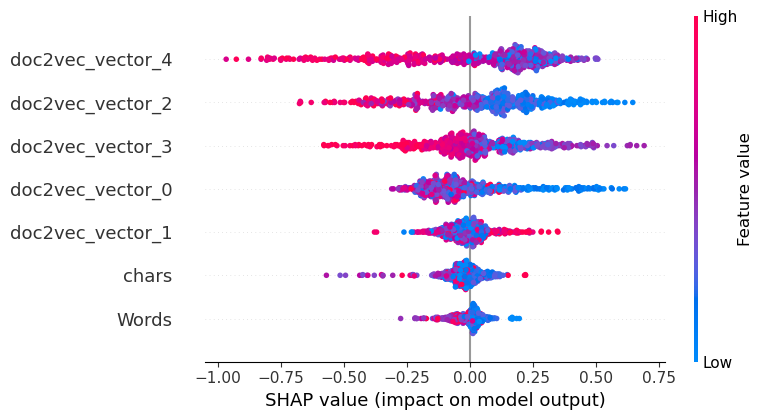

In [32]:
# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test)